# Darts Playground

This notebook provodes a general workflow for forecasting with Darts using the core functionality of the library.

In [57]:
import pandas as pd
import datetime
from darts import TimeSeries
from darts.models import LinearRegressionModel, XGBModel
from darts.utils.statistics import plot_acf, plot_pacf, plot_hist
import matplotlib.pyplot as plt
from darts.metrics import mape


## Load the Data

In [2]:
input = pd.read_csv("./data/us48.csv")
input["period"] = pd.to_datetime(input["period"])
end = input["period"].max().floor(freq = "d")  - datetime.timedelta(hours = 1)
input = input[input["period"] <= end]
input.tail(6)

,period,respondent,respondent-name,type,type-name,value,value-units
77581,2024-05-06 18:00:00,US48,United States Lower 48,D,Demand,482071.0,megawatthours
77582,2024-05-06 19:00:00,US48,United States Lower 48,D,Demand,489916.0,megawatthours
77583,2024-05-06 20:00:00,US48,United States Lower 48,D,Demand,496307.0,megawatthours
77584,2024-05-06 21:00:00,US48,United States Lower 48,D,Demand,502259.0,megawatthours
77585,2024-05-06 22:00:00,US48,United States Lower 48,D,Demand,507154.0,megawatthours
77586,2024-05-06 23:00:00,US48,United States Lower 48,D,Demand,507993.0,megawatthours


## Converting the Pandas DataFrame to Darts Time Series Object

In [3]:
df = input[["period", "value"]].sort_values(by = ["period"])
df

,period,value
0,2015-07-01 05:00:00,162827.0
1,2015-07-01 06:00:00,335153.0
2,2015-07-01 07:00:00,333837.0
3,2015-07-01 08:00:00,398386.0
4,2015-07-01 09:00:00,388954.0
...,...,...
77582,2024-05-06 19:00:00,489916.0
77583,2024-05-06 20:00:00,496307.0
77584,2024-05-06 21:00:00,502259.0
77585,2024-05-06 22:00:00,507154.0


In [4]:
ts = TimeSeries.from_dataframe(df, time_col= "period", value_cols= "value")
print(type(ts))

<class 'darts.timeseries.TimeSeries'>


<Axes: xlabel='period'>

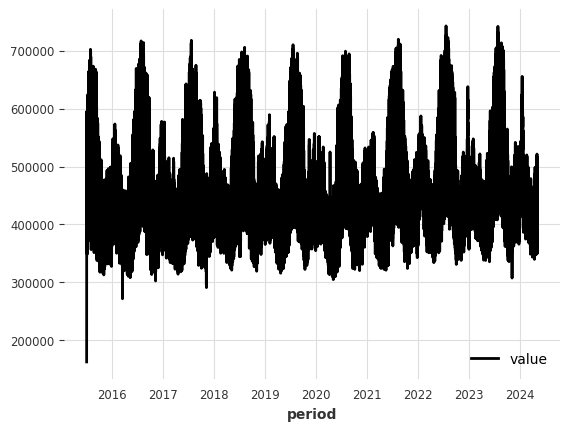

In [5]:
ts.plot()

For the model training we will use the last 2 years:

In [24]:
train_length = 24 * 365 * 2
df = input[["period", "value"]].sort_values(by = ["period"])
df = df.iloc[-(train_length):]
df

,period,value
60067,2022-05-08 00:00:00,453438.0
60068,2022-05-08 01:00:00,451973.0
60069,2022-05-08 02:00:00,446135.0
60070,2022-05-08 03:00:00,433072.0
60071,2022-05-08 04:00:00,415078.0
...,...,...
77582,2024-05-06 19:00:00,489916.0
77583,2024-05-06 20:00:00,496307.0
77584,2024-05-06 21:00:00,502259.0
77585,2024-05-06 22:00:00,507154.0


<Axes: xlabel='period'>

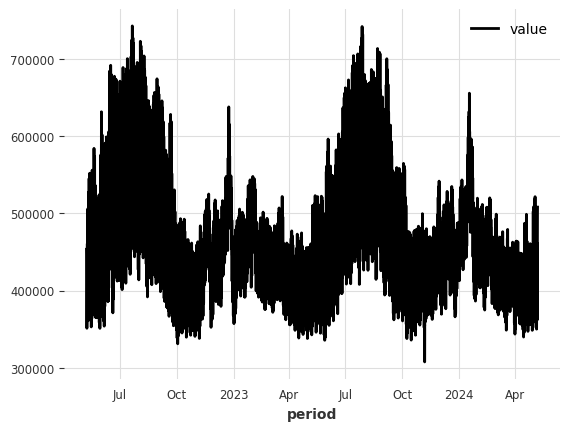

In [25]:
ts = TimeSeries.from_dataframe(df, time_col= "period", value_cols= "value")
ts.plot()

# Time Series Exploratory Analysis

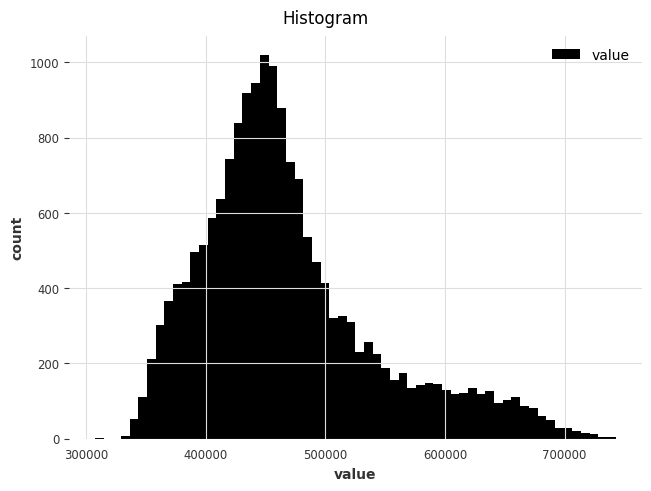

In [26]:
plot_hist(ts, bins = 60)

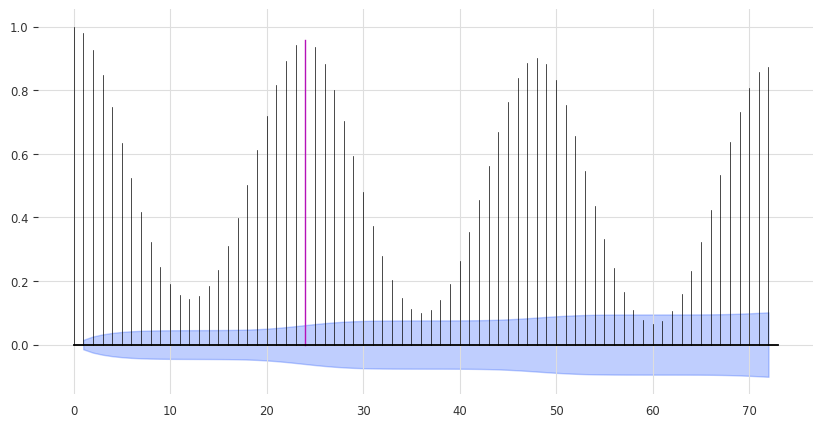

In [27]:
plot_acf(ts, m = 24, max_lag = 72, alpha = 0.05)

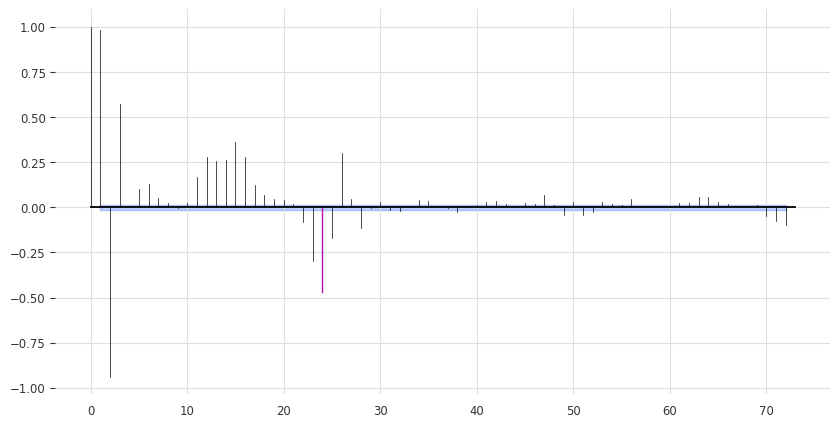

In [28]:
plot_pacf(ts, m = 24, max_lag = 72, alpha = 0.05)

<Axes: xlabel='period'>

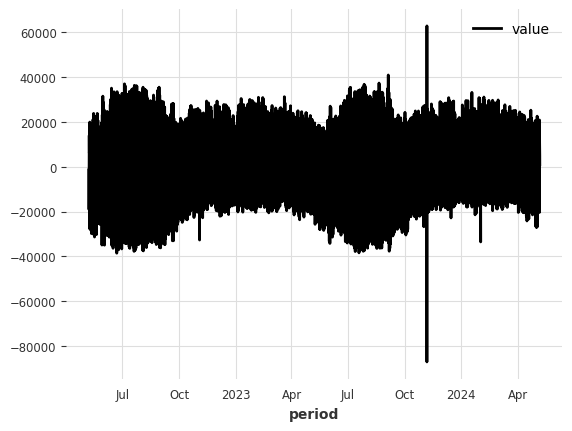

In [29]:
ts.diff().plot()

## Training Forecasting Model

In [40]:
test_length = 72
pi = 0.05
lower = pi/2
upper = 1 - pi/2
lags=[-1, -23,-24, -25, -48]
seed = 12345
num_samples = 100

In [41]:
train, val = ts[:-test_length], ts[-test_length:]

In [42]:
lm_md = LinearRegressionModel(lags = lags,
                     likelihood= "quantile", 
                     random_state = seed,
                     quantiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

In [43]:
lm_md.fit(train)


LinearRegressionModel(lags=[-1, -23, -24, -25, -48], lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=quantile, quantiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95], random_state=12345, multi_models=True, use_static_covariates=True)

In [44]:
prediction = lm_md.predict(test_length, num_samples= num_samples)

MAPE = 3.77%


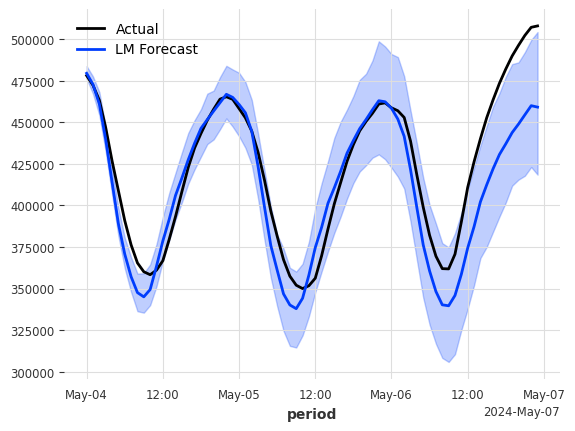

In [49]:
val.plot(label = "Actual")
prediction.plot(label="LM Forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(val, prediction)))

Training XGBoost model:

In [46]:
xg_md = XGBModel(lags = lags,
                 likelihood= "quantile", 
                 random_state = seed,
                 quantiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

In [47]:
xg_md.fit(train)

XGBModel(lags=[-1, -23, -24, -25, -48], lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=quantile, quantiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95], random_state=12345, multi_models=True, use_static_covariates=True)

In [48]:
prediction_xg = xg_md.predict(test_length, num_samples = num_samples)

MAPE = 4.28%


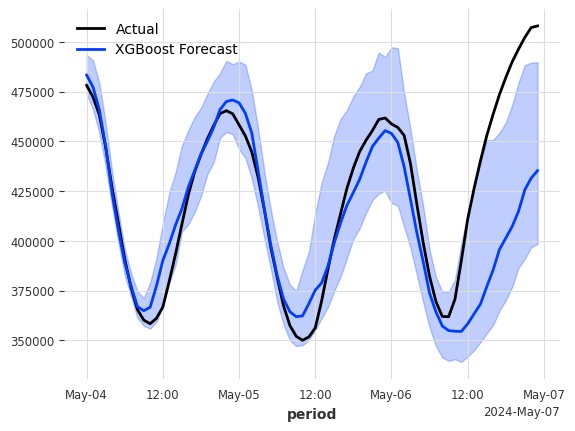

In [50]:
val.plot(label = "Actual")
prediction_xg.plot(label="XGBoost Forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(val, prediction_xg)))

In [51]:
lags_2=[-1,-2, -3,-4, -23,-24, -25, -48]

xg_md_2 = XGBModel(lags = lags_2,
                 likelihood= "quantile", 
                 random_state = seed,
                 quantiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

In [52]:
xg_md_2.fit(train)
prediction_xg_2 = xg_md_2.predict(test_length, num_samples = num_samples)

MAPE = 2.75%


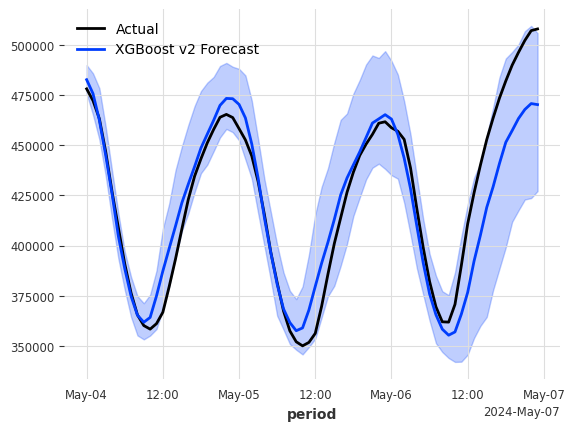

In [53]:
val.plot(label = "Actual")
prediction_xg_2.plot(label="XGBoost v2 Forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(val, prediction_xg_2)))